## **Pytorch一般有以下几个流程**


- 1. 数据读取

- 2. 数据处理

- 3. 搭建网络

- 4. 模型训练

- 5. 模型上线

## 1. 数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 在指定GPU运行，比如第一个GPU就是0，如果多个GPU，就是"0,1"

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchinfo import summary

我仔细想了想，为了结果都可以复现，我这里加了一个设置随机种子的代码，这样也方便大家利用对应的代码能得到相对稳定的结果

In [2]:
from utils import setup_seed
setup_seed(2022)

Random seed set as 2022


**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


这里为了保持ZFNet的结果，还是变成224x224的图片吧

In [3]:
transform = transforms.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    # transforms.RandomCrop(32,padding=4), # 数据增广
    # transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [4]:
Batch_Size = 128

这里的num_workers代表着数据的读取速度，通常取4,8,12,16等，并不是越大越好，除此之外，在windows如果出现问题，就设为0即可

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=8)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. 查看数据（格式，大小，形状）

In [6]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [9]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    

## 3. 查看图片

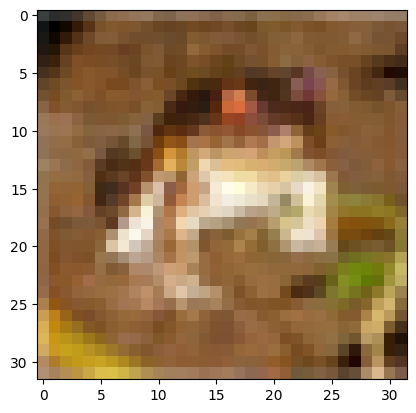

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [11]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

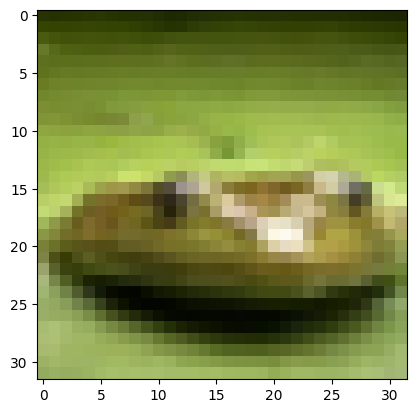

In [12]:
imshow(im[0])

In [13]:
im[0].shape

torch.Size([3, 32, 32])

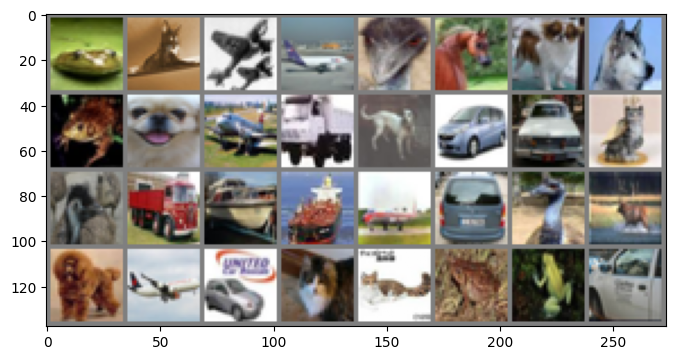

In [14]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

## 4. 定义网络（EfficientNet）

### EfficientNet介绍

EfficientNet源自Google Brain的论文EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. 从标题也可以看出，这篇论文最主要的创新点是**Model Scaling**. 论文提出了**compound scaling**，混合缩放，把网络缩放的三种方式：深度、宽度、分辨率，组合起来按照一定规则缩放，从而提高网络的效果。EfficientNet在网络变大时效果提升明显，把精度上限进一步提升，成为了当前最强网络。EfficientNet-B7在ImageNet上获得了最先进的 84.4%的top-1精度 和 97.1%的top-5精度，比之前最好的卷积网络（GPipe, Top-1: 84.3%, Top-5: 97.0%）大小缩小8.4倍、速度提升6.1倍。

在一般情况下，我们知道，增加网络参数可以获得更好的精度（有足够的数据，不过拟合的条件下），例如ResNet可以加深从ResNet-18到ResNet-200，GPipe将baseline模型放大四倍在ImageNet数据集上获得了84.3%的top-1精度。增加网络参数的方式有三种：**深度**、**宽度**和**分辨率**。

深度是指网络的层数，宽度指网络中卷积的channel数（例如wide resnet中通过增加channel数获得精度收益），分辨率是指通过网络输入大小（例如从112x112到224x224）。在EfficientNet之前，没有研究工作只是针对这三个维度中的某一个维度进行调整，因为**没钱啊！！有限的计算能力**，很少有研究对这三个维度进行综合调整的。

直观上来讲，这三种缩放方式并不不独立。对于分辨率高的图像，应该用更深的网络，因为需要更大的感受野，同时也应该增加网络宽度来获得更细粒度的特征。


#### EfficientNet性能比较

之前增加网络参数都是单独放大这三种方式中的一种，并没有同时调整，也没有调整方式的研究。EfficientNet使用了compound scaling方法，统一缩放网络深度、宽度和分辨率。类似于靠强大的搜索能力和计算能力，EfficientNet的主要创新点并不是结构，不像ResNet、SENet发明了shortcut或attention机制，EfficientNet的base结构是利用结构搜索搜出来的，然后使用compound scaling规则放缩，得到一系列表现优异的网络：B0~B7.下面两幅图分别是ImageNet的Top-1 Accuracy随参数量和flops变化关系图，可以看到EfficientNet饱和值高，并且到达速度快。可以这样说：**对于ImageNet历史上的各种网络而言，可以说EfficientNet在效果上实现了碾压**

![img](https://ask.qcloudimg.com/http-save/yehe-7164815/xz7b66w4mv.jpeg?imageView2/2/w/1620)

![img](https://ask.qcloudimg.com/http-save/yehe-7164815/fxerkdvkxm.jpeg?imageView2/2/w/1620)



#### EfficientNet的baseline

EfficientNet使用了MobileNet V2中的MBCConv作为模型的主干网络，同时也是用了SENet中的squeeze and excitation方法对网络结构进行了优化。MBConv在MobileNet V2中已经介绍过了，SENet会单独在之后的博文中进行详细讲解。

总之呢，综合了MBConv和squeeze and excitation方法的EfficientNet-B0的网络结构如下表所示：

![在这里插入图片描述](https://img-blog.csdnimg.cn/45324d52df3947b79f148f655ab8626d.png)

这里找了一个更形象的图，方便我们理解和进行构建EfficientNet网络。

![Architecture of EfficientNet-B0 with MBConv as Basic building blocks. |  Download Scientific Diagram](https://www.researchgate.net/publication/344410350/figure/fig4/AS:1022373302128641@1620764198841/Architecture-of-EfficientNet-B0-with-MBConv-as-Basic-building-blocks.png)

#### EfficientNet模型混合缩放方法

EfficientNet的规范化混合调参方法使用了一个复合系数 $\phi$ ，来对三个参数进行符合调整：使用了compound scaling方法，统一缩放网络深度、宽度和分辨率。

![img](https://ask.qcloudimg.com/http-save/yehe-7164815/7ble9qa9jf.png?imageView2/2/w/1620)

其中的$\alpha, \beta, \gamma$都是常数，可以通过网格搜索获得。复合系数通过人工调节。考虑到如果网络深度翻番那么对应的计算量翻番，网络宽度和图像分辨率翻番对应的计算量会翻4番，卷积操作的计算量与d ,$w^2 ,r^2$成正比，。在这个约束下，网络的计算量大约是之前的$2^\phi$。

后续就可以利用混合缩放的方法进行对baseline网络进行改进，如下图所示，(a)为baseline网络，(b)、(c)、(d)为单独通过增加width，depth以及resolution使得网络变大的方式，(e)为compound scaling的方式。

![img](https://ask.qcloudimg.com/http-save/yehe-7164815/1bb0ysr530.png?imageView2/2/w/1620)

这样就衍生出了EfficientB1-B7，从上面的图我们可以看到使用了compound scaling后，效果非常显著，在不同参数量和计算量都取得了多倍的提升。EfficientNet在ImageNet上的效果碾压，而且模型规模比此前的GPipe小了8.4倍。

#### 其他版本的EfficientNet(B1-B7)

| Model          | input_size | width_coefficient | depth_coefficient | drop_connect_rate | dropout_rate |
| -------------- | ---------- | ----------------- | ----------------- | ----------------- | ------------ |
| EfficientNetB0 | 224x224    | 1.0               | 1.0               | 0.2               | 0.2          |
| EfficientNetB1 | 240x240    | 1.0               | 1.1               | 0.2               | 0.2          |
| EfficientNetB2 | 260x260    | 1.1               | 1.2               | 0.2               | 0.3          |
| EfficientNetB3 | 300x300    | 1.2               | 1.4               | 0.2               | 0.3          |
| EfficientNetB4 | 380x380    | 1.4               | 1.8               | 0.2               | 0.4          |
| EfficientNetB5 | 456x456    | 1.6               | 2.2               | 0.2               | 0.4          |
| EfficientNetB6 | 528x528    | 1.8               | 2.6               | 0.2               | 0.5          |
| EfficientNetB7 | 600x600    | 2.0               | 3.1               | 0.2               | 0.5          |

- `input_size`代表训练网络时输入网络的图像大小

- `width_coefficient`代表`channel`维度上的倍率因子，比如在 EfficientNetB0中`Stage1`的3x3卷积层所使用的卷积核个数是32，那么在B6中就是$32 \times 1.8=57.6$接着取整到离它最近的8的整数倍即56，其它`Stage`同理。

- `depth_coefficient`代表depth维度上的倍率因子（仅针对`Stage2`到`Stage8`），比如在EfficientNetB0中`Stage7`的${\widehat L}_i=4$,那么在B6中就是$4 \times 2.6=10.4$接着向上取整即11。

- `drop_connect_rate`是在`MBConv`结构中dropout层使用的`drop_rate`，在官方keras模块的实现中`MBConv`结构的`drop_rate`是从0递增到`drop_connect_rate`的（**注意，在源码实现中只有使用shortcut的时候才有Dropout层**），还需要注意的是，这里的Dropout层是`Stochastic Depth`，即会随机丢掉整个block的主分支（只剩捷径分支，相当于直接跳过了这个block）也可以理解为减少了网络的深度。

- `dropout_rate`是最后一个全连接层前的`dropout`层（在`stage9`的Pooling与FC之间）的`dropout_rate`。

  最后给出原论文中关于EfficientNet与当时主流网络的性能参数对比：

  

  ![在这里插入图片描述](https://img-blog.csdnimg.cn/d04580031c1541b3b3a57fa80d015c83.png)





### 判断是否使用GPU

首先我们还是得判断是否可以利用GPU，因为GPU的速度可能会比我们用CPU的速度快20-100倍左右，特别是对卷积神经网络来说，更是提升特别明显。

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

我们首先定义一下激活函数Swish和DropConnect方法，DropConnect是一种正则化方法，它在训练过程中随机将网络中的某些权重设置为0，在有些实现中，大家会使用DropPath进行，也是可以的。

In [16]:
# 激活函数
def swish(x):
    return x * x.sigmoid()

# DropConnect是一种正则化方法，它在训练过程中随机将网络中的某些权重设置为0
# DropConnect是对网络中每一个权重进行随机设置的
def drop_connect(x, drop_ratio):
    keep_ratio = 1.0 - drop_ratio
    mask = torch.empty([x.shape[0], 1, 1, 1], dtype=x.dtype, device=x.device)
    mask.bernoulli_(keep_ratio) 
    x.div_(keep_ratio)
    x.mul_(mask)
    return x

### SE模块

有时候对于SE模块来说，我们会用1x1的卷积层实现，因为在这里，实际上1x1的卷积层是等价于全连接层，也就是Linear层的

SE模块如下所示，由一个全局平均池化，两个全连接层组成。第一个全连接层的节点个数是输入该`MBConv`特征矩阵`channels`的$ \frac{1}{4} $，且使用Swish激活函数。第二个全连接层的节点个数等于`Depthwise Conv`层输出的特征矩阵`channels`，且使用Sigmoid激活函数。



![semodule](https://img-blog.csdnimg.cn/20210306151615976.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center)

In [17]:
# SE模块实现
class SE(nn.Module):
    '''Squeeze-and-Excitation MBconv with Swish.'''

    def __init__(self, in_channels, se_channels):
        super(SE, self).__init__()
        # 这里的1x1的卷积核与全连接层是等价的
        self.se1 = nn.Conv2d(in_channels, se_channels,
                             kernel_size=1, bias=True) 
        self.se2 = nn.Conv2d(se_channels, in_channels,
                             kernel_size=1, bias=True)

    def forward(self, x):
        out = F.adaptive_avg_pool2d(x, (1, 1)) # 平均池化
        out = swish(self.se1(out))
        out = self.se2(out).sigmoid()
        out = x * out # 进行连接相乘
        return out

### MBConv 结构

![在这里插入图片描述](https://img-blog.csdnimg.cn/d722212185f74df8afc1c7303e0eb5bf.png#pic_center)

如图所示，MBConv 结构主要由一个 **1x1 的普通卷积（升维作用）**，一个 kxk 的 Depthwise Conv 卷积。k 的具体值主要有 3x3 和 5x5 两种情况，一个 SE 模块，一个 **1x1 的普通卷积（降维作用）**，一个 Droupout 层构成

- 第一个升维的 1x1 卷积层，它的卷积核个数是输入特征矩阵 **channel 的 n 倍**，n ∈ { 1 , 6 }
- 当 n = 1 时，不要第一个升维的 1x1 卷积层，即 Stage2 中的 MBConv 结构都没有第一个升维的 1x1 卷积层（这和MobileNetV3网络类似）。

- 仅当输入 MBConv 结构的特征矩阵与输出的特征矩阵 **shape 相同时才存在 shortcut** 连接（代码中可通过`stride==1 and inputc_channels==output_channels`条件来判断）。
- 在源码实现中**只有使用 shortcut 的时候才有 Dropout 层**

In [18]:
# MBconv模块
class MBconv(nn.Module):
    '''expansion + depthwise + pointwise + squeeze-excitation'''

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 expand_ratio=1,
                 se_ratio=0.25, # 也就是1/4
                 drop_rate=0.):
        super(MBconv, self).__init__()
        self.stride = stride
        self.drop_rate = drop_rate
        self.expand_ratio = expand_ratio

        # Expansion 第一个升维的 1x1 卷积层
        channels = expand_ratio * in_channels
        self.conv1 = nn.Conv2d(in_channels,
                               channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(channels)

        # Depthwise conv
        self.conv2 = nn.Conv2d(channels,
                               channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=(1 if kernel_size == 3 else 2),
                               groups=channels,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

        # SE layers SE模块
        se_channels = int(in_channels * se_ratio)
        self.se = SE(channels, se_channels)

        # Output
        self.conv3 = nn.Conv2d(channels,
                               out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Skip connection if in and out shapes are the same (MV-V2 style)
        # 仅当输入 MBConv 结构的特征矩阵与输出的特征矩阵 shape 相同时才存在 shortcut 连接
        self.has_skip = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # 当n = 1的时候，是不要第一个升维的1x1的卷积层
        out = x if self.expand_ratio == 1 else swish(self.bn1(self.conv1(x)))
        out = swish(self.bn2(self.conv2(out)))
        out = self.se(out)
        out = self.bn3(self.conv3(out))
        if self.has_skip:
            if self.training and self.drop_rate > 0: # 有shortcut的时候用Dropout
                out = drop_connect(out, self.drop_rate)
            out = out + x
        return out

### 定义EfficientNet的网络

这样我们就可以根据EFficientNet的论文的架构定义我们的网络，用到上述的SE模块和MBconv模块进行

In [19]:
# 定义EfficientNet方法
class EfficientNet(nn.Module):
    # 默认识别的类别为10
    def __init__(self,
                 width_coefficient=1.0,
                 depth_coefficient=1.0,
                 dropout_rate = 0.2,
                 num_classes=10):
        super(EfficientNet, self).__init__()
        # kernel_size, in_channel, out_channel, exp_ratio, strides, use_SE, drop_connect_rate, repeats
        cfg = {
            'num_blocks': [1, 2, 2, 3, 3, 4, 1], # repeats
            'expansion': [1, 6, 6, 6, 6, 6, 6], # expansion
            'out_channels': [16, 24, 40, 80, 112, 192, 320], # out_channels
            'kernel_size': [3, 3, 5, 3, 5, 5, 3], # kernel_size
            'stride': [1, 2, 2, 2, 1, 2, 1], # stride
            'dropout_rate': dropout_rate,
            'drop_connect_rate': 0.2,
        }
        # 配置文件
        self.cfg = cfg
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        # 第一个3x3的卷积层
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(cfg['out_channels'][-1]*int(self.width_coefficient), num_classes)

    def _make_layers(self, in_channels):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_channels', 'num_blocks', 'kernel_size', 'stride']]
        b = 0
        blocks = sum(self.cfg['num_blocks'])
        for expansion, out_channels, num_blocks, kernel_size, stride in zip(*cfg):
            import math
            num_blocks = math.floor(self.depth_coefficient) * num_blocks
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                drop_rate = self.cfg['drop_connect_rate'] * b / blocks
                layers.append(
                    MBconv(in_channels,
                          out_channels*int(self.width_coefficient),
                          kernel_size,
                          stride,
                          expansion,
                          se_ratio=0.25,
                          drop_rate=drop_rate))
                in_channels = out_channels*int(self.width_coefficient)
        return nn.Sequential(*layers)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        dropout_rate = self.cfg['dropout_rate']
        if self.training and dropout_rate > 0:
            out = F.dropout(out, p=dropout_rate)
        out = self.linear(out)
        return out

### 定义EfficientNetB0~B7

在上面我们已经定义了两个参数，我们可以根据参数的配置，进行设置，这样就可以定义出我们的EfficientNetB0~B7的模型

In [20]:
def EfficientNetB0(num_classes = 10):
    # input image size 224x224
    return EfficientNet(width_coefficient=1.0,
                        depth_coefficient=1.0,
                        num_classes=num_classes)

def EfficientNetB1(num_classes = 10):
    # input image size 240x240
    return EfficientNet(width_coefficient=1.0,
                        depth_coefficient=1.1,
                        num_classes=num_classes)

def EfficientNetB2(num_classes = 10):
    # input image size 260x260
    return EfficientNet(width_coefficient=1.1,
                        depth_coefficient=1.2,
                        dropout_rate=0.3,
                        num_classes=num_classes)

def EfficientNetB3(num_classes = 10):
    # input image size 300x300
    return EfficientNet(width_coefficient=1.2,
                        depth_coefficient=1.4,
                        dropout_rate=0.3,
                        num_classes=num_classes)
    
def EfficientNetB4(num_classes = 10):
    # input image size 380x380
    return EfficientNet(width_coefficient=1.4,
                        depth_coefficient=1.8,
                        dropout_rate=0.4,
                        num_classes=num_classes)
    
def EfficientNetB5(num_classes = 10):
    # input image size 456x456
    return EfficientNet(width_coefficient=1.6,
                        depth_coefficient=2.2,
                        dropout_rate=0.4,
                        num_classes=num_classes)

def EfficientNetB6(num_classes = 10):
    # input image size 528x528
    return EfficientNet(width_coefficient=1.8,
                        depth_coefficient=2.6,
                        dropout_rate=0.5,
                        num_classes=num_classes)

def EfficientNetB7(num_classes = 10):
    # input image size 600x600
    return EfficientNet(width_coefficient=2.0,
                        depth_coefficient=3.1,
                        dropout_rate=0.5,
                        num_classes=num_classes)


In [21]:
net = EfficientNetB0(num_classes = 10).to(device)

### summary查看网络

我们可以通过summary来看到，模型的维度的变化，经过层后shape的变化，是否最后也是输出(batch,shape)

In [22]:
summary(net,(2,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
EfficientNet                             [2, 10]                   --
├─Conv2d: 1-1                            [2, 32, 32, 32]           864
├─BatchNorm2d: 1-2                       [2, 32, 32, 32]           64
├─Sequential: 1-3                        [2, 320, 2, 2]            --
│    └─MBconv: 2-1                       [2, 16, 32, 32]           1,088
│    │    └─Conv2d: 3-1                  [2, 32, 32, 32]           288
│    │    └─BatchNorm2d: 3-2             [2, 32, 32, 32]           64
│    │    └─SE: 3-3                      [2, 32, 32, 32]           552
│    │    └─Conv2d: 3-4                  [2, 16, 32, 32]           512
│    │    └─BatchNorm2d: 3-5             [2, 16, 32, 32]           32
│    └─MBconv: 2-2                       [2, 24, 16, 16]           --
│    │    └─Conv2d: 3-6                  [2, 96, 32, 32]           1,536
│    │    └─BatchNorm2d: 3-7             [2, 96, 32, 32]           192
│   

### 测试和定义网络

我们也可以打印出我们的模型观察一下

In [23]:
print(net)

EfficientNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): MBconv(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SE(
        (se1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (se2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): MBconv(
      (conv1): Conv2d(16, 96, kernel_size=(1, 1), stride

接下来可以简单测试一下，是否输入后能得到我们的正确的维度shape

In [24]:
test_x = torch.randn(2,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([2, 10])


定义网络和设置类别

In [25]:
net = EfficientNetB0(num_classes=10)

## 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier

损失函数是封装在神经网络工具箱nn中的,包含很多损失函数

这里我使用的是SGD + momentum算法，并且我们损失函数定义为交叉熵函数，除此之外学习策略定义为动态更新学习率，如果5次迭代后，训练的损失并没有下降，那么我们便会更改学习率，会变为原来的0.5倍，最小降低到0.00001

如果想更加了解优化器和学习率策略的话，可以参考以下资料

- [Pytorch Note15 优化算法1 梯度下降（Gradient descent varients）](https://blog.csdn.net/weixin_45508265/article/details/117859824)
- [Pytorch Note16 优化算法2 动量法(Momentum)](https://blog.csdn.net/weixin_45508265/article/details/117874046)
- [Pytorch Note34 学习率衰减](https://blog.csdn.net/weixin_45508265/article/details/119089705)

这里决定迭代10次

In [26]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
optimizer = optim.AdamW(net.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 10

## 6. 训练及可视化（增加TensorBoard可视化）

首先定义模型保存的位置

In [27]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/EfficientNet-B0.pth'

文件已存在


这次更新了tensorboard的可视化，可以得到更好看的图片，并且能可视化出不错的结果

In [29]:
# 使用tensorboard
from torch.utils.tensorboard import SummaryWriter
os.makedirs("./logs", exist_ok=True)
tbwriter = SummaryWriter(log_dir='./logs/EfficientNet-B0', comment='EfficientNet-B0')  # 使用tensorboard记录中间输出
tbwriter.add_graph(model= net, input_to_model=torch.randn(size=(2, 3, 32, 32)))

如果存在GPU可以选择使用GPU进行运行，并且可以设置并行运算

In [30]:
if device == 'cuda':
    net.to(device)
    net = nn.DataParallel(net) # 使用并行运算

### 开始训练

我定义了一个train函数，在train函数中进行一个训练，并保存我们训练后的模型，这一部分一定要注意，这里的utils文件是我个人写的，所以需要下载下来

或者可以参考我们的工具函数篇，我还更新了结果和方法。

In [31]:
from utils import plot_history
from utils import train
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, tbwriter, verbose = True)

Test Epoch 1/10: 100%|██████████| 79/79 [00:03<00:00, 25.05it/s, Test Acc=0.458, Test Loss=1.65]


Epoch [  1/ 10]  Train Loss:1.670216  Train Acc:37.75% Test Loss:1.651851  Test Acc:45.83%  Learning Rate:0.010000


Test Epoch 2/10: 100%|██████████| 79/79 [00:03<00:00, 19.84it/s, Test Acc=0.634, Test Loss=1.05]


Epoch [  2/ 10]  Train Loss:1.115703  Train Acc:60.13% Test Loss:1.049351  Test Acc:63.43%  Learning Rate:0.010000


Test Epoch 3/10: 100%|██████████| 79/79 [00:03<00:00, 24.33it/s, Test Acc=0.703, Test Loss=0.856]


Epoch [  3/ 10]  Train Loss:0.888298  Train Acc:68.83% Test Loss:0.856442  Test Acc:70.28%  Learning Rate:0.010000


Test Epoch 4/10: 100%|██████████| 79/79 [00:03<00:00, 25.79it/s, Test Acc=0.743, Test Loss=0.738]


Epoch [  4/ 10]  Train Loss:0.762550  Train Acc:73.53% Test Loss:0.738470  Test Acc:74.34%  Learning Rate:0.010000


Test Epoch 5/10: 100%|██████████| 79/79 [00:03<00:00, 22.48it/s, Test Acc=0.75, Test Loss=0.713] 


Epoch [  5/ 10]  Train Loss:0.666550  Train Acc:77.13% Test Loss:0.712513  Test Acc:75.05%  Learning Rate:0.010000


Test Epoch 6/10: 100%|██████████| 79/79 [00:03<00:00, 24.28it/s, Test Acc=0.772, Test Loss=0.693]


Epoch [  6/ 10]  Train Loss:0.601911  Train Acc:79.35% Test Loss:0.693019  Test Acc:77.20%  Learning Rate:0.010000


Test Epoch 7/10: 100%|██████████| 79/79 [00:03<00:00, 25.42it/s, Test Acc=0.775, Test Loss=0.655]


Epoch [  7/ 10]  Train Loss:0.559702  Train Acc:80.86% Test Loss:0.654783  Test Acc:77.52%  Learning Rate:0.010000


Test Epoch 8/10: 100%|██████████| 79/79 [00:03<00:00, 23.75it/s, Test Acc=0.795, Test Loss=0.614]


Epoch [  8/ 10]  Train Loss:0.510548  Train Acc:82.48% Test Loss:0.614094  Test Acc:79.46%  Learning Rate:0.010000


Test Epoch 9/10: 100%|██████████| 79/79 [00:03<00:00, 25.49it/s, Test Acc=0.789, Test Loss=0.634]


Epoch [  9/ 10]  Train Loss:0.482006  Train Acc:83.40% Test Loss:0.634270  Test Acc:78.88%  Learning Rate:0.010000


Test Epoch 10/10: 100%|██████████| 79/79 [00:04<00:00, 19.49it/s, Test Acc=0.76, Test Loss=0.742] 

Epoch [ 10/ 10]  Train Loss:0.455699  Train Acc:84.36% Test Loss:0.742326  Test Acc:76.05%  Learning Rate:0.010000


### 训练曲线可视化

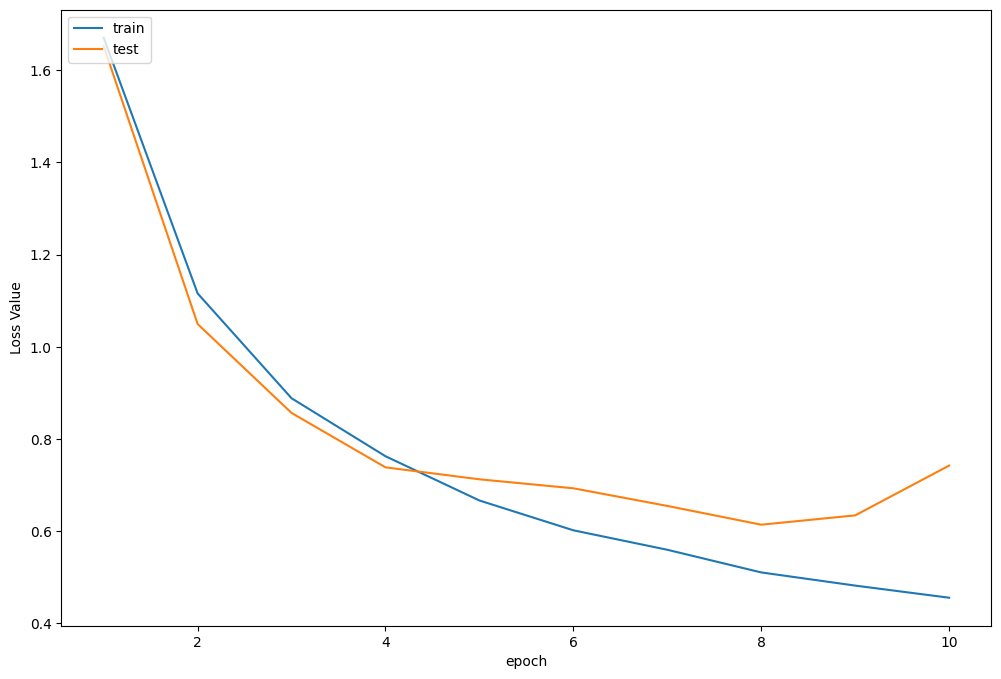

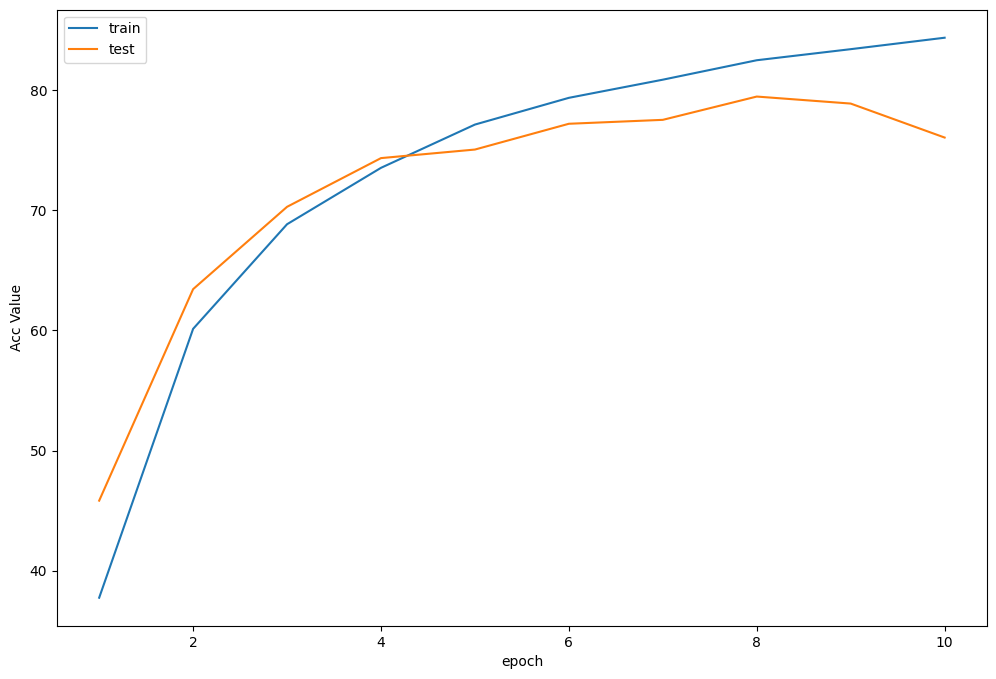

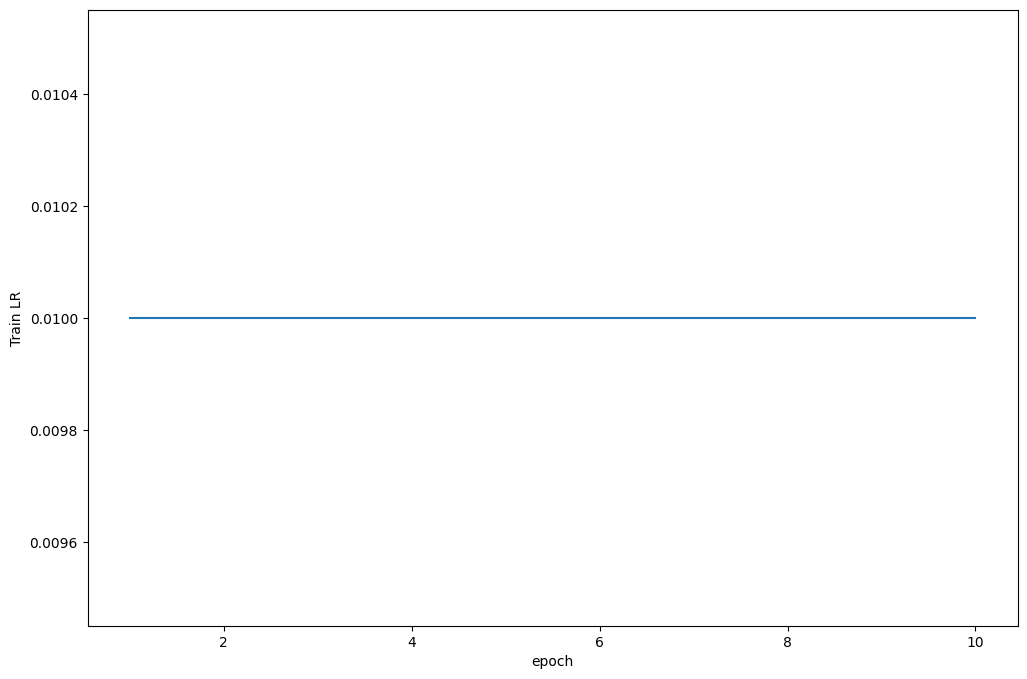

In [43]:
plot_history(epoch ,Acc, Loss, Lr)

可以运行以下代码进行tensorboard可视化

```bash
tensorboard --logdir logs
```

## 7. 测试

### 查看准确率

In [33]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0

for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 76.13 %


程序中的 `torch.max(outputs.data, 1)` ，返回一个tuple (元组)

而这里很明显，这个返回的元组的第一个元素是image data，即是最大的 值，第二个元素是label， 即是最大的值 的 索引！我们只需要label（最大值的索引），所以就会有` _ `,predicted这样的赋值语句，表示忽略第一个返回值，把它赋值给` _`， 就是舍弃它的意思；

### 查看每一类的准确率

In [34]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        #(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有len(iamges)张图片，所以还需要一个len(iamges)的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 80.40 %
Accuracy of automobile : 92.20 %
Accuracy of  bird : 75.70 %
Accuracy of   cat : 52.30 %
Accuracy of  deer : 50.00 %
Accuracy of   dog : 75.80 %
Accuracy of  frog : 64.40 %
Accuracy of horse : 92.60 %
Accuracy of  ship : 89.10 %
Accuracy of truck : 88.80 %


### 抽样测试并可视化一部分结果

Accuracy Rate = 78.125%


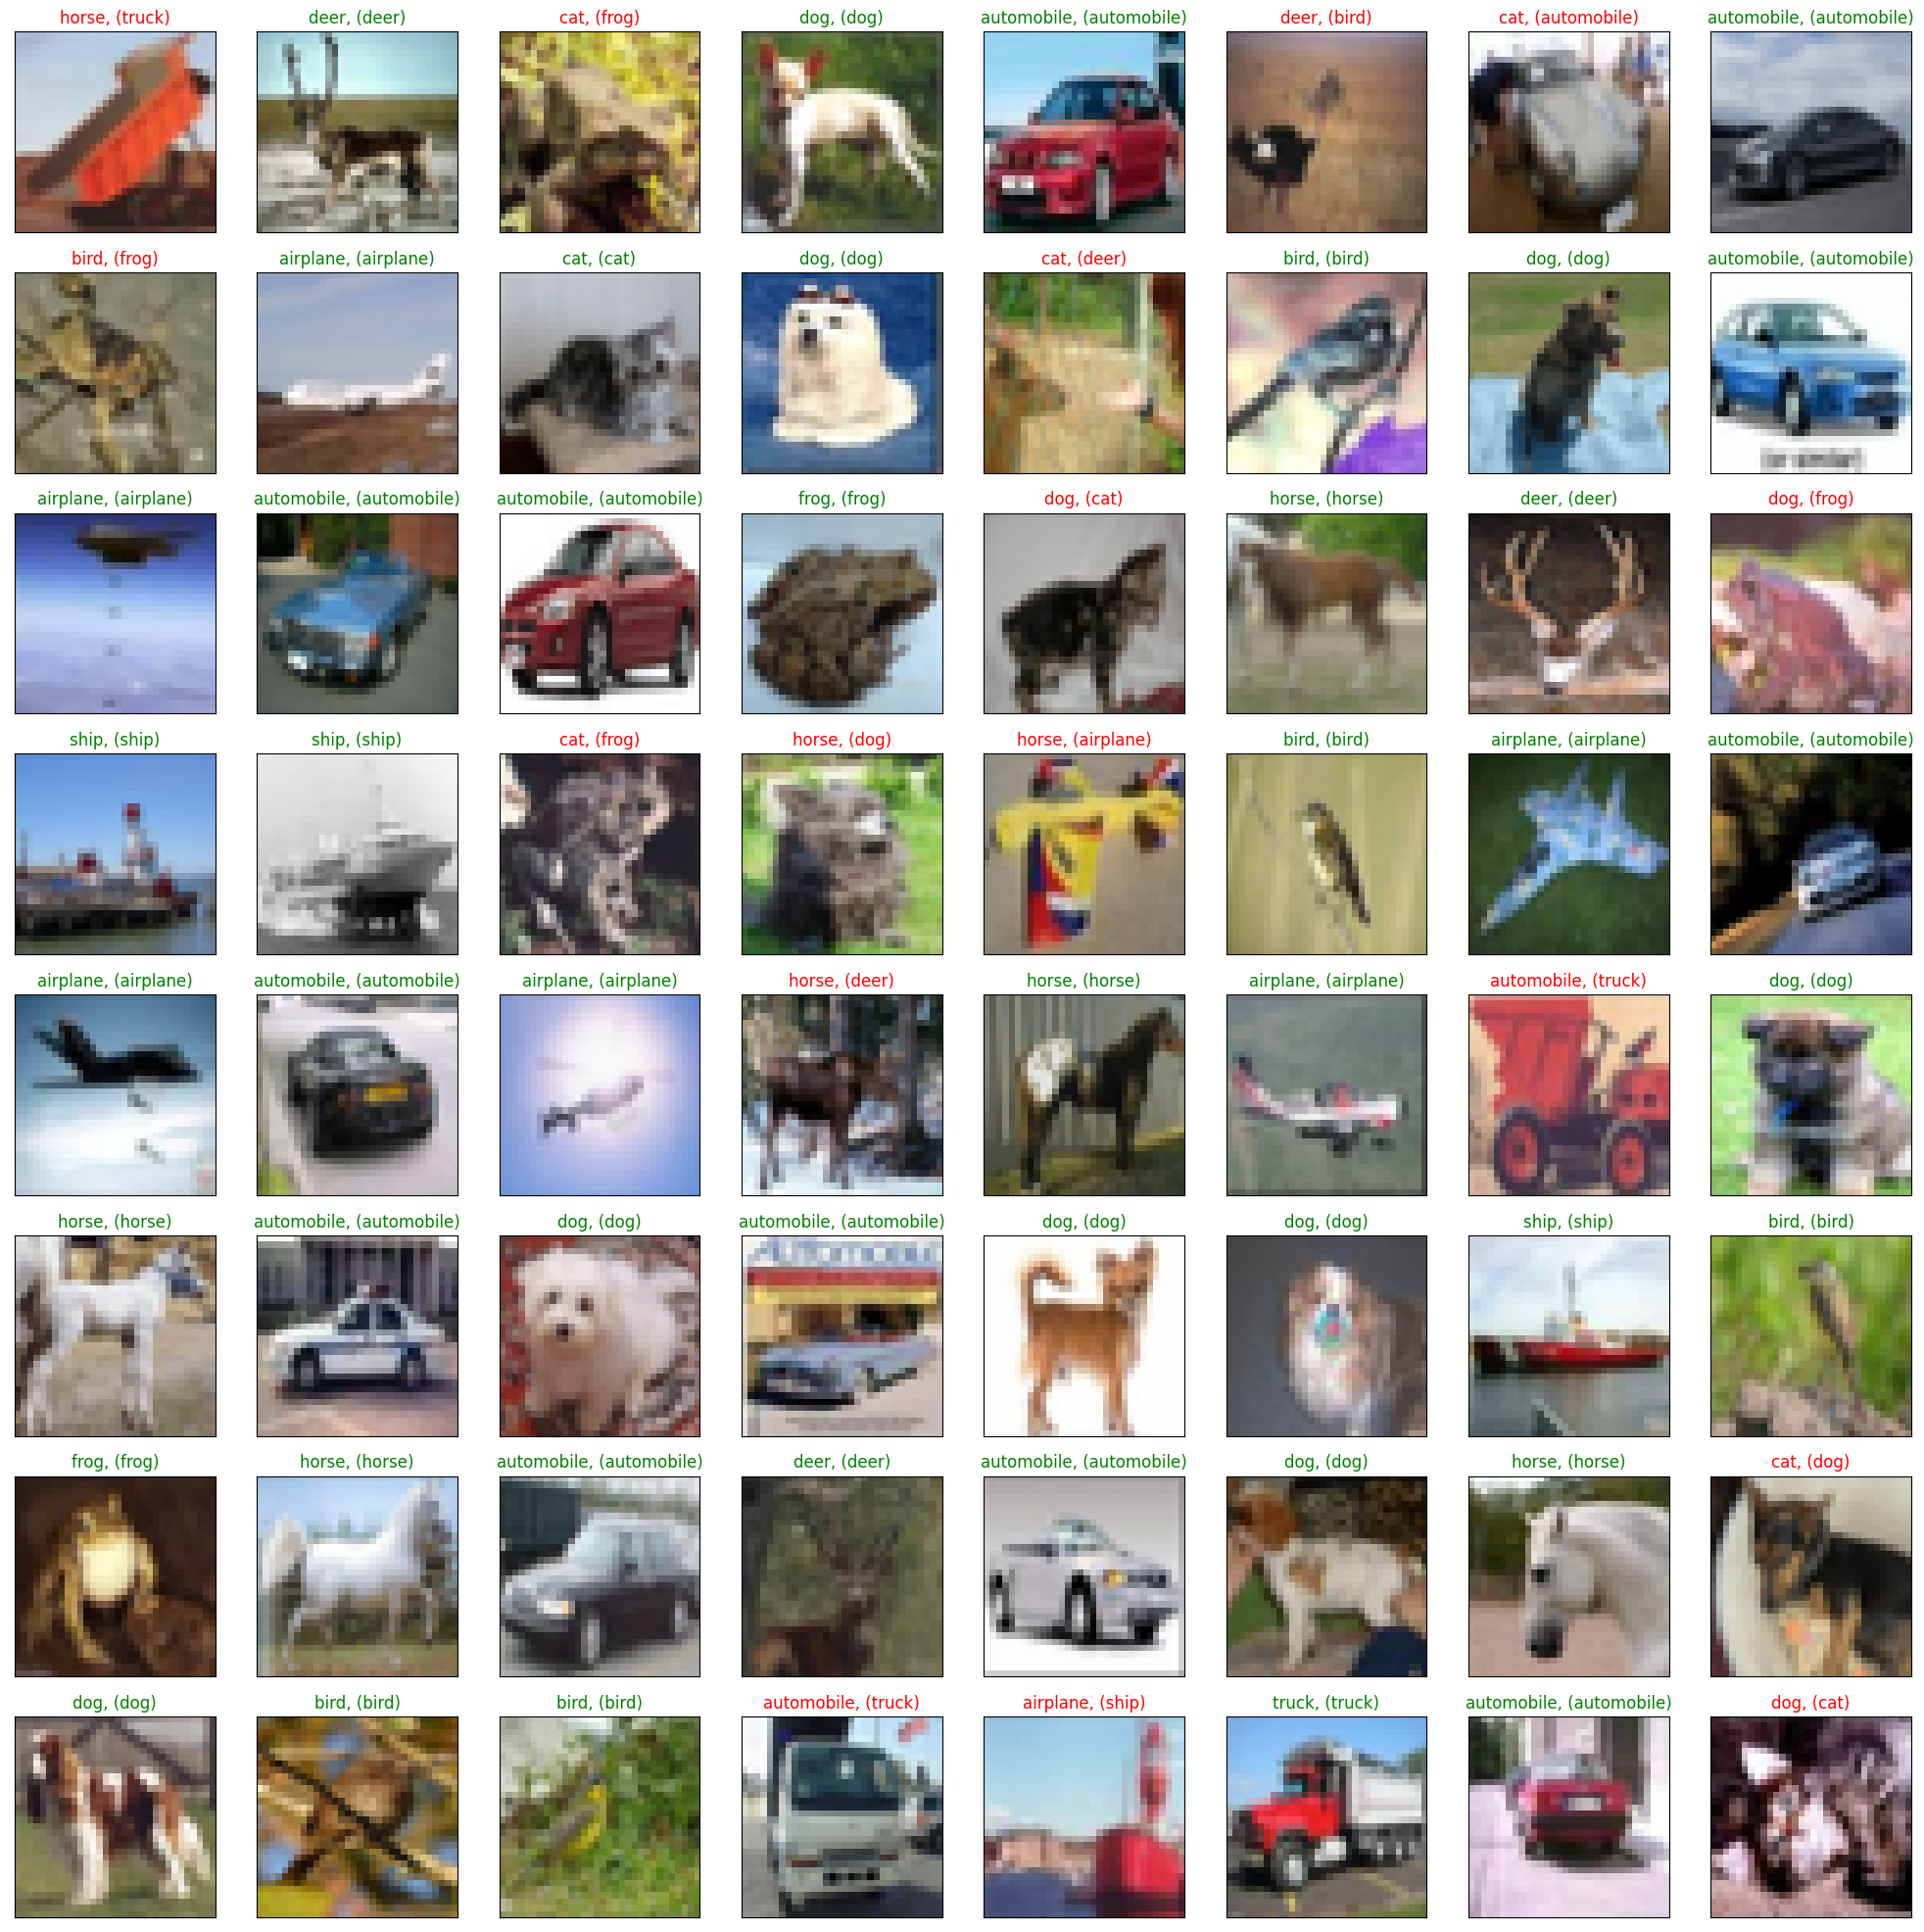

In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images_,labels = images.to(device),labels.to(device)
val_output = net(images_)

_, val_preds = torch.max(val_output, 1)
correct = torch.sum(val_preds == labels.data).item()
val_preds,labels = val_preds.cpu(),labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

### 8. 保存模型

这里保存成前面设定的模型的名字

In [36]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')

## 9. 预测

In [46]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EfficientNetB0(num_classes=10)

model = torch.load(save_path, map_location="cpu")  # 加载模型
model.to(device)
model.eval()  # 把模型转为test模式

DataParallel(
  (module): EfficientNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): MBconv(
        (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (se): SE(
          (se1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (se2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): MBconv

并且为了方便，定义了一个predict函数，简单思想就是，先resize成网络使用的shape，然后进行变化tensor输入即可，不过这里有一个点，我们需要对我们的图片也进行transforms，因为我们的训练的时候，对每个图像也是进行了transforms的，所以我们需要保持一致

In [54]:
def predict(model, img):
    trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
    img = trans(img)
    img = img.to(device)
    # 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
    img = img.unsqueeze(0)  # 扩展后，为[1，3，32，32]
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是10个分类的概率
    print("概率",prob)
    value, predicted = torch.max(output.data, 1)
    print("类别",predicted.item())
    print(value)
    pred_class = classes[predicted.item()]
    print("分类",pred_class)

### 读取本地图片进行预测

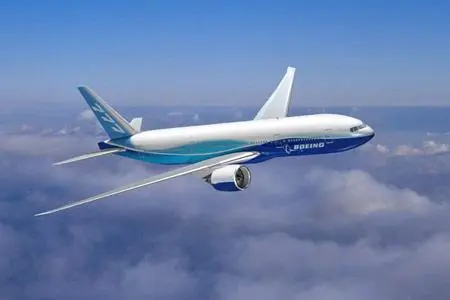

In [55]:
# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像
img

In [56]:
predict(model, img)

概率 tensor([[9.9339e-01, 1.9589e-05, 4.6372e-04, 2.1349e-06, 3.1111e-05, 6.9647e-07,
         1.7551e-06, 4.4248e-06, 5.8533e-03, 2.3146e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
类别 0
tensor([9.4914], device='cuda:0')
分类 airplane


### 读取图片地址进行预测

我们也可以通过读取图片的url地址进行预测，这里我找了多个不同的图片进行预测

<Response [200]>


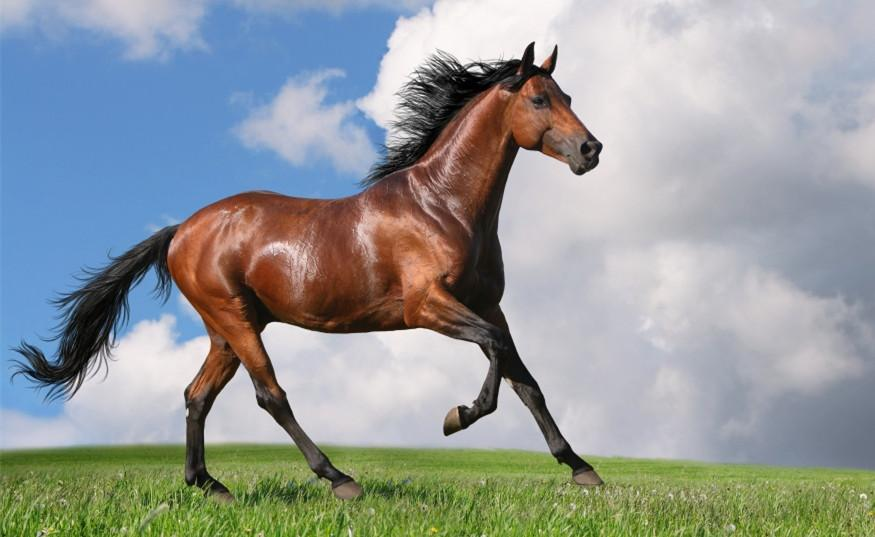

In [59]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://img2.baidu.com/it/u=3210145212,1163645841&fm=253&fmt=auto&app=120&f=JPEG?w=875&h=537' # horse
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [60]:
predict(model, img)

概率 tensor([[1.5856e-03, 2.1046e-04, 3.9647e-03, 1.0489e-02, 7.3925e-02, 4.8408e-02,
         3.3223e-04, 8.6051e-01, 1.6616e-04, 4.1264e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
类别 7
tensor([5.2634], device='cuda:0')
分类 horse
